In [1]:
# Model Performance Analysis and Explainability

# Cell 1: Setup
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Setup paths
if 'notebooks' in str(Path.cwd()):
    PROJECT_ROOT = Path.cwd().parent
else:
    PROJECT_ROOT = Path.cwd()

sys.path.insert(0, str(PROJECT_ROOT / 'src'))

from utils.metrics import RegressionMetrics

print("✓ Imports successful")
print(f"Project root: {PROJECT_ROOT}")

✓ Imports successful
Project root: d:\Dev\Projects\qrucible


In [3]:
# Cell 2: Load Trained Models
print("\n" + "="*70)
print("LOADING TRAINED MODELS")
print("="*70)

models_dir = PROJECT_ROOT / 'results' / 'models'

# Check available models
available_models = list(models_dir.glob('*.pkl'))
print(f"\nFound {len(available_models)} trained models:")
for model_path in available_models:
    print(f"  - {model_path.name}")

# Load models
loaded_models = {}

for model_path in available_models:
    model_name = model_path.stem
    try:
        model_data = joblib.load(model_path)
        loaded_models[model_name] = model_data
        print(f"\n✓ Loaded: {model_name}")
    except Exception as e:
        print(f"\n✗ Failed to load {model_name}: {e}")



LOADING TRAINED MODELS

Found 4 trained models:
  - random_forest.pkl
  - random_forest_fingerprints.pkl
  - xgboost.pkl
  - xgboost_fingerprints.pkl

✓ Loaded: random_forest

✓ Loaded: random_forest_fingerprints

✓ Loaded: xgboost

✓ Loaded: xgboost_fingerprints


In [5]:
# Cell 3: Load Test Data and Predictions
data_file = PROJECT_ROOT / 'data' / 'processed' / 'chembl_egfr_kinase_clean.csv'
df = pd.read_csv(data_file)

# Prepare features (same as training)
feature_cols = ['mol_weight', 'logp', 'tpsa', 'num_h_donors', 'num_h_acceptors',
                'num_rotatable_bonds', 'n_heavy_atoms', 'lipinski_violations']

available_features = [col for col in feature_cols if col in df.columns]
print(f"\n✓ Using {len(available_features)} features: {available_features}")

X = df[available_features]
y = df['pIC50']

# Split (same random state as training)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nData split: Train={len(X_train)}, Test={len(X_test)}")


✓ Using 8 features: ['mol_weight', 'logp', 'tpsa', 'num_h_donors', 'num_h_acceptors', 'num_rotatable_bonds', 'n_heavy_atoms', 'lipinski_violations']

Data split: Train=7379, Test=1845


In [6]:
# Cell 4: Model Performance Comparison
print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)

# Make predictions with all models
predictions = {}

for model_name, model_data in loaded_models.items():
    try:
        model = model_data['model']
        scaler = model_data.get('scaler')
        
        # Scale if needed
        X_test_scaled = scaler.transform(X_test) if scaler else X_test
        
        y_pred = model.predict(X_test_scaled)
        predictions[model_name] = y_pred
        
        # Calculate metrics
        metrics = RegressionMetrics.calculate_all_metrics(y_test, y_pred)
        
        print(f"\n{model_name}:")
        print(f"  R²: {metrics['r2']:.4f}")
        print(f"  RMSE: {metrics['rmse']:.4f}")
        print(f"  MAE: {metrics['mae']:.4f}")
        print(f"  Pearson r: {metrics['pearson_r']:.4f}")
        
    except Exception as e:
        print(f"\n✗ Error with {model_name}: {e}")



MODEL PERFORMANCE COMPARISON

random_forest:
  R²: 0.6743
  RMSE: 0.6923
  MAE: 0.5157
  Pearson r: 0.8447

✗ Error with random_forest_fingerprints: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

xgboost:
  R²: 0.5856
  RMSE: 0.7809
  MAE: 0.5959
  Pearson r: 0.7814

✗ Error with xgboost_fingerprints: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.



PREDICTION VISUALIZATIONS


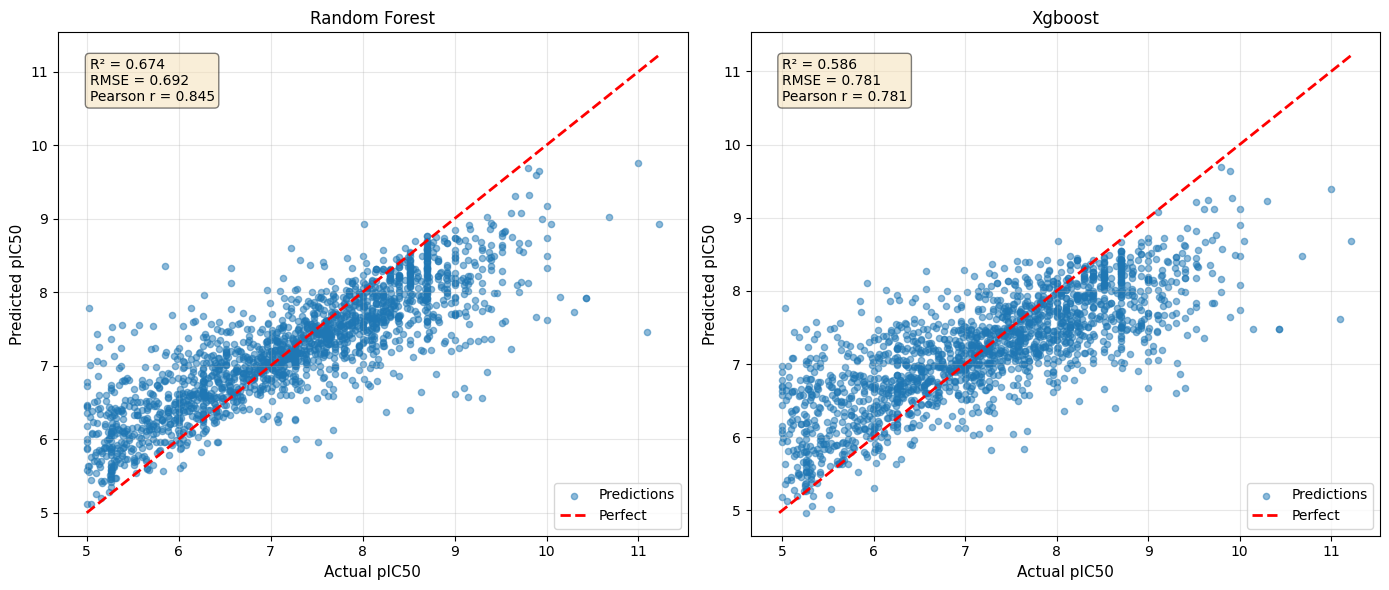

In [7]:
# Cell 5: Prediction Plots
print("\n" + "="*70)
print("PREDICTION VISUALIZATIONS")
print("="*70)

n_models = len(predictions)
if n_models > 0:
    n_cols = min(2, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 6*n_rows))
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (model_name, y_pred) in enumerate(predictions.items()):
        ax = axes[idx]
        
        # Scatter plot
        ax.scatter(y_test, y_pred, alpha=0.5, s=20, label='Predictions')
        
        # Perfect prediction line
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
        
        # Metrics
        metrics = RegressionMetrics.calculate_all_metrics(y_test, y_pred)
        
        textstr = f"R² = {metrics['r2']:.3f}\nRMSE = {metrics['rmse']:.3f}\nPearson r = {metrics['pearson_r']:.3f}"
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        ax.set_xlabel('Actual pIC50', fontsize=11)
        ax.set_ylabel('Predicted pIC50', fontsize=11)
        ax.set_title(f'{model_name.replace("_", " ").title()}', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for idx in range(len(predictions), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()



RESIDUAL ANALYSIS


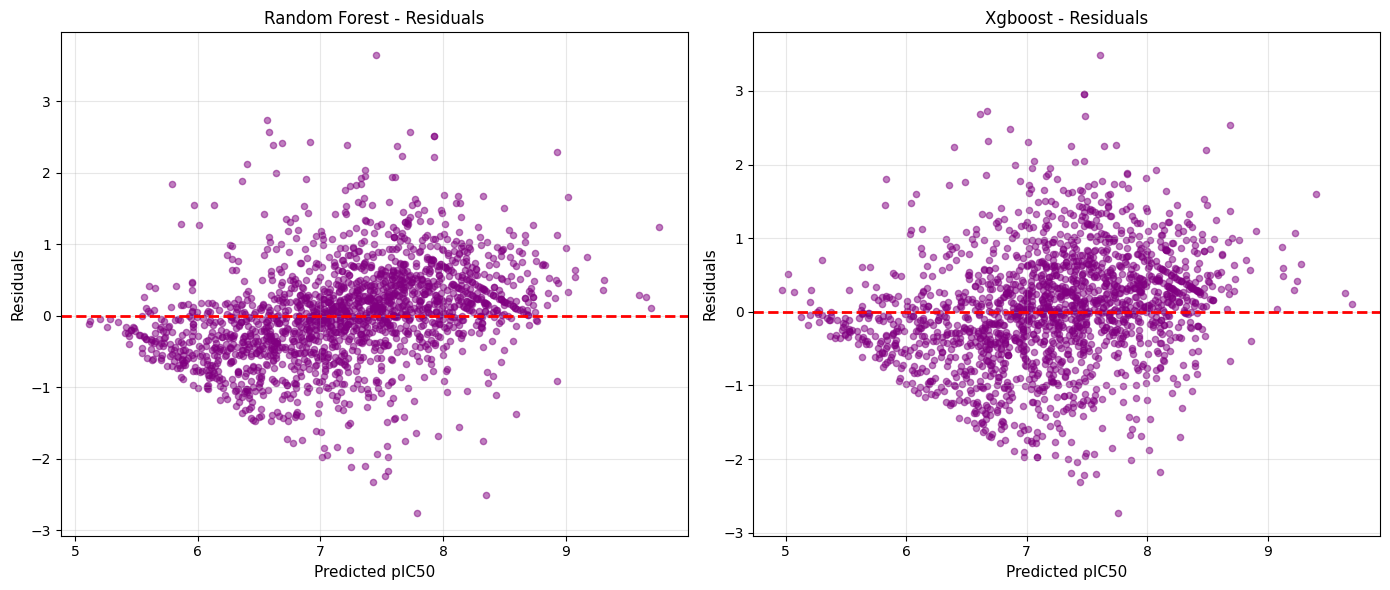

In [8]:
# Cell 6: Residual Analysis
print("\n" + "="*70)
print("RESIDUAL ANALYSIS")
print("="*70)

if predictions:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 6*n_rows))
    if n_models == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (model_name, y_pred) in enumerate(predictions.items()):
        ax = axes[idx]
        
        residuals = y_test - y_pred
        
        # Residual plot
        ax.scatter(y_pred, residuals, alpha=0.5, s=20, color='purple')
        ax.axhline(y=0, color='r', linestyle='--', lw=2)
        
        ax.set_xlabel('Predicted pIC50', fontsize=11)
        ax.set_ylabel('Residuals', fontsize=11)
        ax.set_title(f'{model_name.replace("_", " ").title()} - Residuals', fontsize=12)
        ax.grid(True, alpha=0.3)
    
    for idx in range(len(predictions), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()



FEATURE IMPORTANCE ANALYSIS


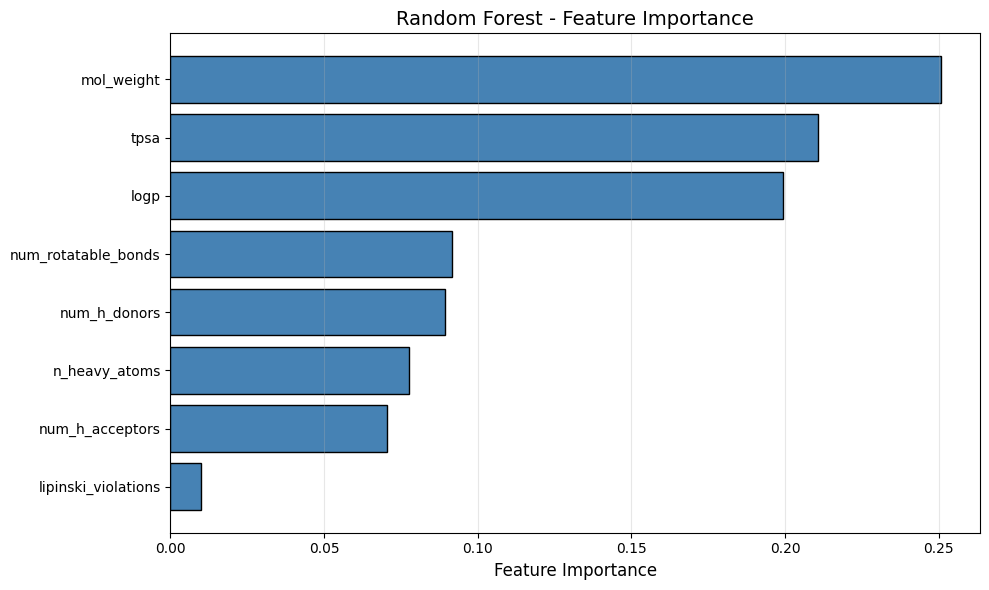


Top 5 Most Important Features:
1. mol_weight.............................. 0.2509
2. tpsa.................................... 0.2106
3. logp.................................... 0.1993
4. num_rotatable_bonds..................... 0.0917
5. num_h_donors............................ 0.0893


In [9]:
# Cell 7: Feature Importance (Random Forest)
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

rf_model_data = loaded_models.get('random_forest')

if rf_model_data:
    model = rf_model_data['model']
    feature_names = rf_model_data.get('feature_names', available_features)
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importances)), importances[indices], color='steelblue', edgecolor='black')
    plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title('Random Forest - Feature Importance', fontsize=14)
    plt.grid(True, alpha=0.3, axis='x')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 Most Important Features:")
    for i in range(min(5, len(importances))):
        idx = indices[i]
        print(f"{i+1}. {feature_names[idx]:.<40} {importances[idx]:.4f}")



SHAP ANALYSIS

Calculating SHAP values (this may take a moment)...


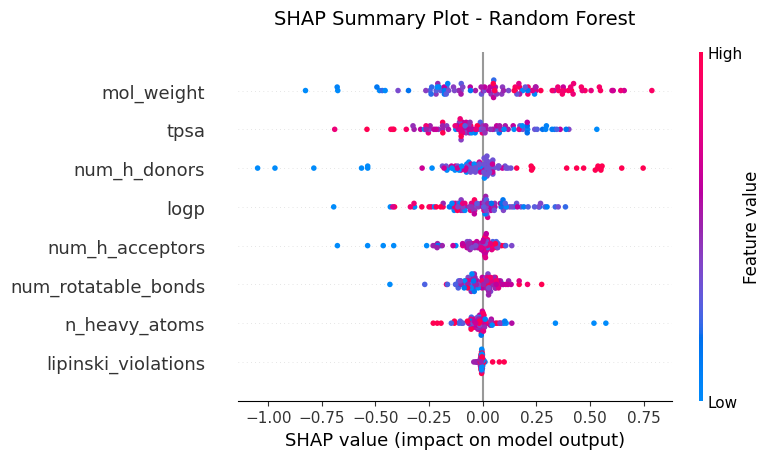


✓ SHAP analysis complete


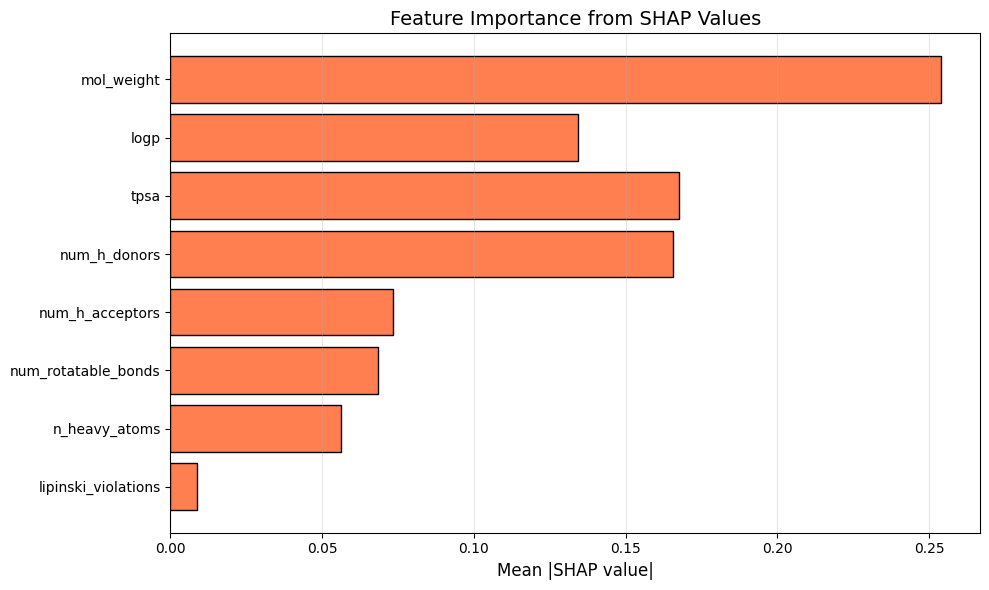

In [10]:
# Cell 8: SHAP Analysis (if installed)
print("\n" + "="*70)
print("SHAP ANALYSIS")
print("="*70)

try:
    import shap
    
    if rf_model_data:
        print("\nCalculating SHAP values (this may take a moment)...")
        
        model = rf_model_data['model']
        scaler = rf_model_data.get('scaler')
        
        # Use a sample for SHAP (computationally expensive)
        sample_size = min(100, len(X_test))
        X_test_sample = X_test.iloc[:sample_size]
        X_test_scaled = scaler.transform(X_test_sample) if scaler else X_test_sample
        
        # Create explainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_scaled)
        
        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test_sample, 
                         feature_names=available_features,
                         show=False)
        plt.title('SHAP Summary Plot - Random Forest', fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()
        
        print("\n✓ SHAP analysis complete")
        
        # Feature importance from SHAP
        shap_importance = np.abs(shap_values).mean(axis=0)
        
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(shap_importance)), shap_importance, color='coral', edgecolor='black')
        plt.yticks(range(len(shap_importance)), available_features)
        plt.xlabel('Mean |SHAP value|', fontsize=12)
        plt.title('Feature Importance from SHAP Values', fontsize=14)
        plt.grid(True, alpha=0.3, axis='x')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
except ImportError:
    print("\n⚠ SHAP not installed. Install with: pip install shap")
    print("  SHAP provides detailed model explainability")


PREDICTION ERROR DISTRIBUTION


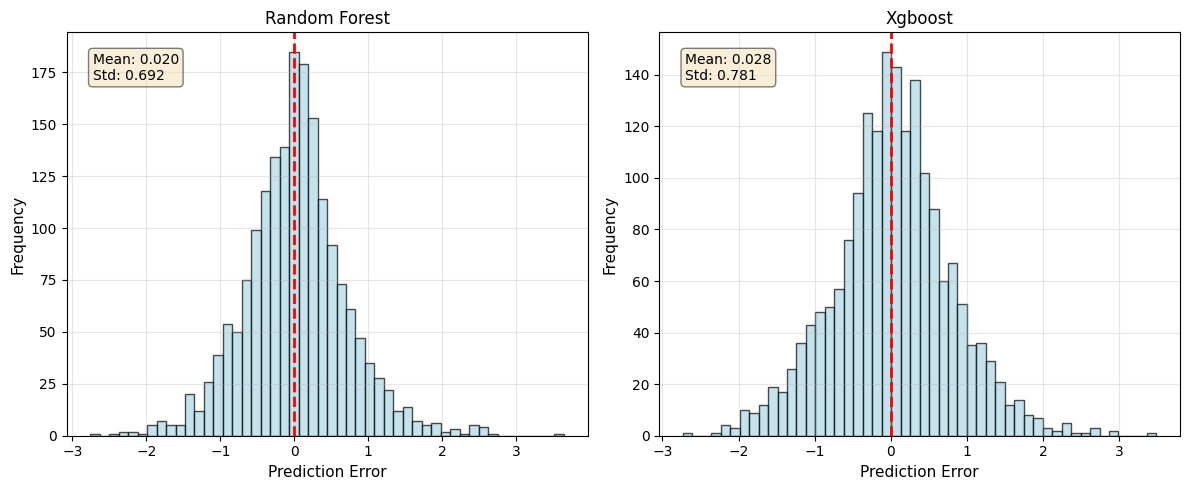

In [11]:
# Cell 9: Prediction Error Distribution
print("\n" + "="*70)
print("PREDICTION ERROR DISTRIBUTION")
print("="*70)

if predictions:
    fig, axes = plt.subplots(1, len(predictions), figsize=(6*len(predictions), 5))
    if len(predictions) == 1:
        axes = [axes]
    
    for idx, (model_name, y_pred) in enumerate(predictions.items()):
        errors = y_test - y_pred
        
        axes[idx].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='lightblue')
        axes[idx].axvline(x=0, color='r', linestyle='--', lw=2)
        axes[idx].set_xlabel('Prediction Error', fontsize=11)
        axes[idx].set_ylabel('Frequency', fontsize=11)
        axes[idx].set_title(f'{model_name.replace("_", " ").title()}', fontsize=12)
        axes[idx].grid(True, alpha=0.3)
        
        # Add statistics
        mean_error = errors.mean()
        std_error = errors.std()
        axes[idx].text(0.05, 0.95, 
                      f'Mean: {mean_error:.3f}\nStd: {std_error:.3f}',
                      transform=axes[idx].transAxes,
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()



ACTIVITY DISTRIBUTION COMPARISON


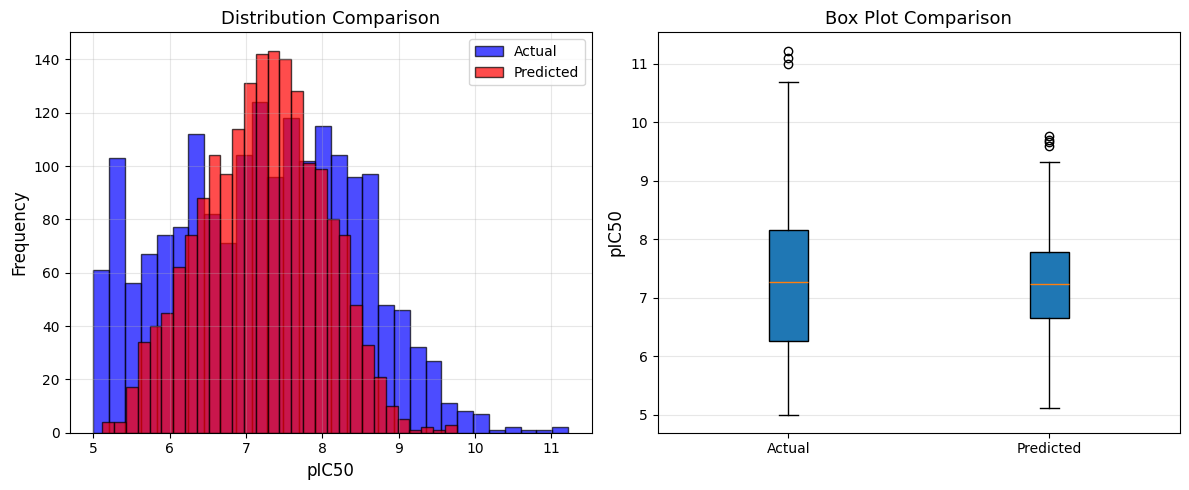

In [12]:
# Cell 10: Activity Distribution Comparison
print("\n" + "="*70)
print("ACTIVITY DISTRIBUTION COMPARISON")
print("="*70)

if predictions:
    # Use first model for demonstration
    first_model = list(predictions.keys())[0]
    y_pred = predictions[first_model]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(y_test, bins=30, alpha=0.7, label='Actual', color='blue', edgecolor='black')
    plt.hist(y_pred, bins=30, alpha=0.7, label='Predicted', color='red', edgecolor='black')
    plt.xlabel('pIC50', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution Comparison', fontsize=13)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.boxplot([y_test, y_pred], labels=['Actual', 'Predicted'], patch_artist=True)
    plt.ylabel('pIC50', fontsize=12)
    plt.title('Box Plot Comparison', fontsize=13)
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()



PERFORMANCE BY ACTIVITY RANGE

Performance by Activity Range:
         Range  Count        R²     RMSE      MAE
      Low (<6)    350 -7.980355 0.885672 0.738979
  Medium (6-7)    422 -2.036071 0.507125 0.386001
    High (7-8)    531 -0.920355 0.402819 0.295940
Very High (>8)    542 -1.774500 0.875058 0.687713


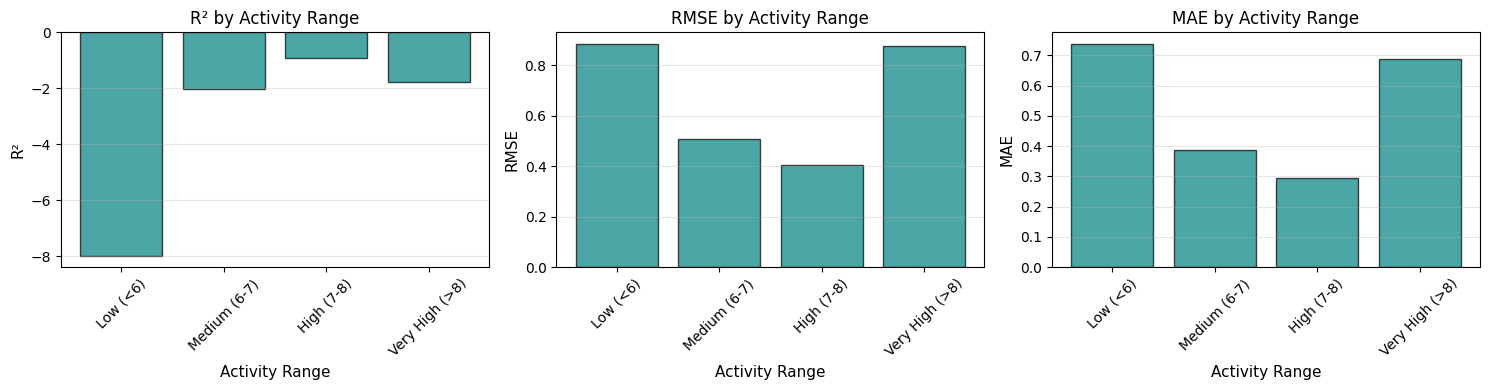

In [13]:
# Cell 11: Performance by Activity Range
print("\n" + "="*70)
print("PERFORMANCE BY ACTIVITY RANGE")
print("="*70)

if predictions:
    first_model = list(predictions.keys())[0]
    y_pred = predictions[first_model]
    
    # Define activity bins
    bins = [0, 6, 7, 8, 100]
    labels = ['Low (<6)', 'Medium (6-7)', 'High (7-8)', 'Very High (>8)']
    
    y_test_binned = pd.cut(y_test, bins=bins, labels=labels)
    
    # Calculate metrics per bin
    results = []
    for label in labels:
        mask = y_test_binned == label
        if mask.sum() > 0:
            y_true_bin = y_test[mask]
            y_pred_bin = y_pred[mask]
            
            metrics = RegressionMetrics.calculate_all_metrics(y_true_bin, y_pred_bin)
            
            results.append({
                'Range': label,
                'Count': mask.sum(),
                'R²': metrics['r2'],
                'RMSE': metrics['rmse'],
                'MAE': metrics['mae']
            })
    
    results_df = pd.DataFrame(results)
    print("\nPerformance by Activity Range:")
    print(results_df.to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, metric in enumerate(['R²', 'RMSE', 'MAE']):
        axes[idx].bar(results_df['Range'], results_df[metric], 
                     color='teal', edgecolor='black', alpha=0.7)
        axes[idx].set_xlabel('Activity Range', fontsize=11)
        axes[idx].set_ylabel(metric, fontsize=11)
        axes[idx].set_title(f'{metric} by Activity Range', fontsize=12)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


In [14]:
# Cell 12: Model Comparison Summary
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

if predictions:
    comparison = []
    
    for model_name, y_pred in predictions.items():
        metrics = RegressionMetrics.calculate_all_metrics(y_test, y_pred)
        
        comparison.append({
            'Model': model_name.replace('_', ' ').title(),
            'R²': metrics['r2'],
            'RMSE': metrics['rmse'],
            'MAE': metrics['mae'],
            'Pearson r': metrics['pearson_r']
        })
    
    comparison_df = pd.DataFrame(comparison)
    print("\n" + comparison_df.to_string(index=False))
    
    # Save comparison
    output_path = PROJECT_ROOT / 'results' / 'reports' / 'model_comparison.csv'
    comparison_df.to_csv(output_path, index=False)
    print(f"\n✓ Saved comparison to: {output_path}")

print("\n✅ Model Analysis Complete!")
print("\n📝 Key Insights:")
print("  - Check feature importance to understand model decisions")
print("  - Analyze residuals to identify systematic errors")
print("  - Compare models to select the best performer")
print("="*70)



MODEL COMPARISON SUMMARY

        Model       R²     RMSE      MAE  Pearson r
Random Forest 0.674344 0.692295 0.515675   0.844661
      Xgboost 0.585624 0.780924 0.595942   0.781414

✓ Saved comparison to: d:\Dev\Projects\qrucible\results\reports\model_comparison.csv

✅ Model Analysis Complete!

📝 Key Insights:
  - Check feature importance to understand model decisions
  - Analyze residuals to identify systematic errors
  - Compare models to select the best performer
